In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [45]:
metadata = pd.read_csv( "../data/raw/metadata.csv", parse_dates=["scene_start"])
print(metadata.shape)
metadata.shape

(1084, 6)


(1084, 6)

In [46]:
metadata.head()

,image_id,chip_id,flood_id,polarization,location,scene_start
0,awc00_vh,awc00,awc,vh,Bolivia,2018-02-15
1,awc00_vv,awc00,awc,vv,Bolivia,2018-02-15
2,awc01_vh,awc01,awc,vh,Bolivia,2018-02-15
3,awc01_vv,awc01,awc,vv,Bolivia,2018-02-15
4,awc02_vh,awc02,awc,vh,Bolivia,2018-02-15


In [47]:
import rasterio 

DATA_PATH = '../data/raw/'
EXT = '.tif'

_id = metadata.chip_id[0]

path = DATA_PATH + '/nasadem/' + _id + EXT
with rasterio.open(path) as img:
    nasadem = img.read(1)

In [48]:
import matplotlib.colors as colors
from pysheds.grid import Grid
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

grid = Grid.from_raster(path, data_name='dem')
grid

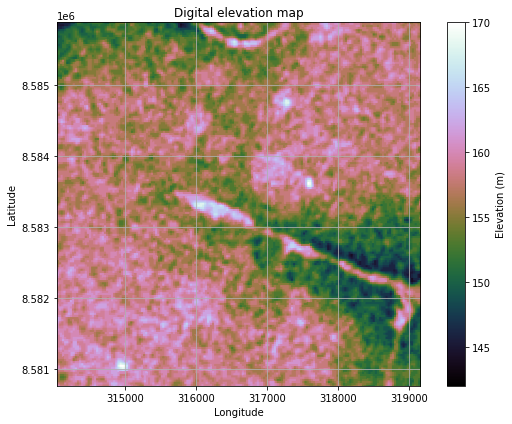

In [49]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(grid.dem, extent=grid.extent, cmap='cubehelix', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
#plt.savefig('img/conditioned_dem.png', bbox_inches='tight')

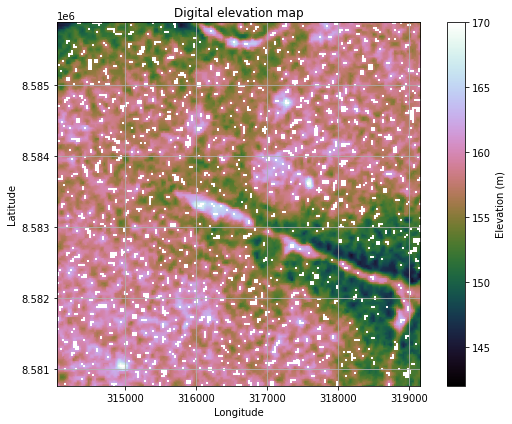

In [50]:
grid.resolve_flats('dem', out_name='inflated_dem')

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(grid.inflated_dem, extent=grid.extent, cmap='cubehelix', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

In [51]:
#N    NE    E    SE    S    SW    W    NW
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)
grid.flowdir(data='inflated_dem', out_name='dir', dirmap=dirmap)

In [52]:
grid.dir

Raster([[  0,   0,   0, ...,   0,   0,   0],
        [  0,  16,  64, ...,  -1,  -1,   0],
        [  0,  16,  16, ...,  64,  64,   0],
        ...,
        [  0,  16,   1, ...,  64,   1,   0],
        [  0,  16, 128, ...,  64, 128,   0],
        [  0,   0,   0, ...,   0,   0,   0]])

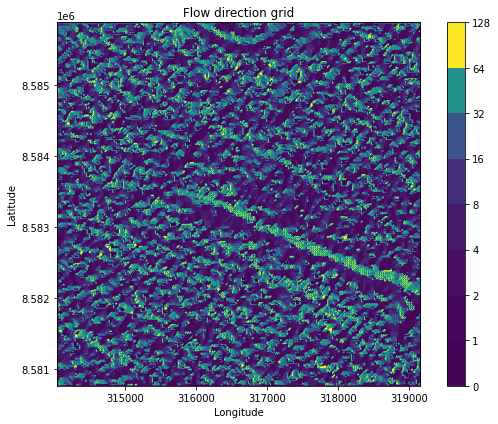

In [53]:
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(grid.dir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid')
plt.grid(zorder=-1)
plt.tight_layout()
#plt.savefig('img/flow_direction.png', bbox_inches='tight')

In [54]:
grid.accumulation(data='dir', dirmap=dirmap, out_name='acc')

Text(0, 0.5, 'Latitude')

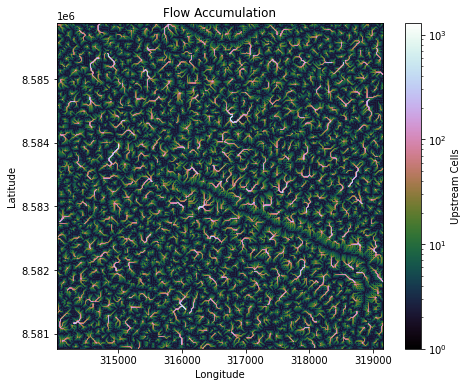

In [55]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
acc_img = np.where(grid.mask, grid.acc + 1, np.nan)
im = ax.imshow(acc_img, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, grid.acc.max()))
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.savefig('img/flow_accumulation.png', bbox_inches='tight')

In [56]:
grid.flow_distance(data='dir', dirmap=dirmap, out_name='dist', x=256,y=256)

Text(0.5, 1.0, 'Flow Distance')

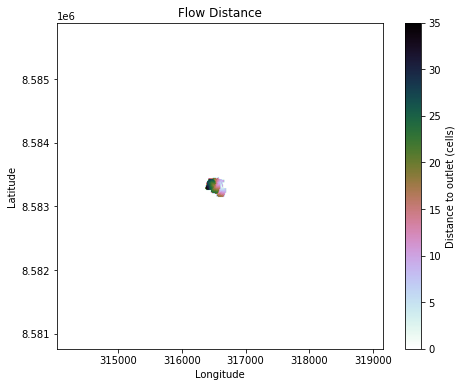

In [57]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(grid.dist, extent=grid.extent, zorder=2,
               cmap='cubehelix_r')
plt.colorbar(im, ax=ax, label='Distance to outlet (cells)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow Distance')
#plt.savefig('img/flow_distance.png', bbox_inches='tight')

In [72]:
hand = grid.compute_hand('dir', 'dem', grid.acc > 200, inplace=False)

Text(0.5, 1.0, 'Height above nearest drainage')

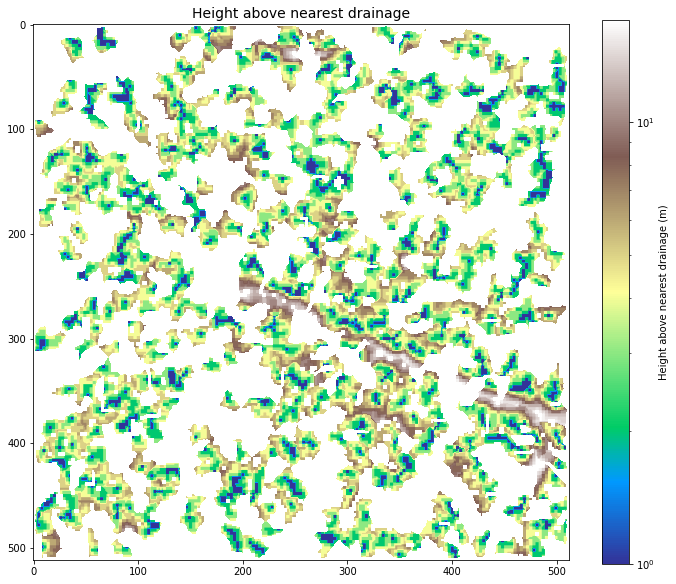

In [73]:
fig, ax = plt.subplots(figsize=(12,10))
plt.imshow(hand + 1, zorder=1, cmap='terrain', interpolation='bilinear',
           norm=colors.LogNorm(vmin=1, vmax=np.nanmax(hand)))
plt.colorbar(label='Height above nearest drainage (m)')
plt.title('Height above nearest drainage', size=14)